In [116]:
import os
from skimage.filters import threshold_otsu
import pandas as pd
import numpy as np
import tifffile
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import  tqdm
import trackpy as tp

In [63]:
def remove_disc(_img, r =20, value = 0):
    """
    Remove a disc from an image.

    :param _img: The input image to remove the disc from.
    :param r: The radius of the disc. Default value is 20.
    :param value: The value to set inside the disc. Default value is 0.
    :return: The image with the disc removed.

    Example usage:
        _img = cv2.imread("image.jpg")
        removed_img = remove_disc(_img, r=30, value=255)
    """
    _img = _img.copy()
    # Define the center and radius of the disk
    center = (img.shape[0]//2, _img.shape[1]//2)
    
    # Create index arrays to img
    x = np.arange(0, img.shape[1])
    y = np.arange(0, img.shape[0])

    # Create boolean mask with disk pixel positions set to True
    mask = (x[np.newaxis, :] - center[0]) ** 2 + (y[:, np.newaxis] - center[1]) ** 2 < r ** 2

    # Apply mask to the image
    _img[mask] = value  # or whatever value you wish to set inside the mask
    return _img



In [117]:
DATA_PATH = r'C:\Users\amityu\Gel_Drop_Data'
MOVIE_PATH = os.path.join(DATA_PATH , 'tif_centered')
#MOVIE_PATH = os.path.join(DATA_PATH, 'eye_gel')

# tiff source
#output_dir = r'C:\Users\amityu\Gel_Drop_Data\yuval_clip\\'
output_dir = r'C:\Users\amityu\Gel_Drop_Data\175_950_ex1_clip\\'

files = os.listdir(MOVIE_PATH)
files= sorted(files)
files = files[175:950] #take only relevant files

In [118]:
# read all images
only_quarter = False
img_list = []
for file in tqdm(files):
    img = tifffile.imread(os.path.join(MOVIE_PATH, file))
    if only_quarter:
        img[img.shape[0]//2:,:] = 0
        img[:, img.shape[1]//2:] = 0

    img_list.append(img)
image_array = np.array(img_list)


  0%|          | 0/775 [00:00<?, ?it/s]

In [119]:
#clipping for visualization to adjust image contrast
for file in tqdm(files):
    img = tifffile.imread(os.path.join(MOVIE_PATH, file))
    data = img.flatten()
    data = data[~np.isnan(data)]
    threshold = threshold_otsu(data)
    threshold_data = data[data > threshold]
    threshold2 = np.percentile(threshold_data, 5)
    img=np.clip(img, threshold2, np.percentile(img, 99))
    tifffile.imwrite(os.path.join(output_dir,file), img)
    


  0%|          | 0/775 [00:00<?, ?it/s]

In [4]:
# put crosses in visualization to create ROI for the trackmate plugin to find
# only for exploation purpuses, for production use trackpy
def paint_indices_cross(_img,indices):
    mask = np.zeros_like(_img)
    indices = np.array(indices)
    for j in range(len(indices)):
        x = int(indices[j,1])
        y = int(indices[j,0])
        mask [max(y-1,0):min(y+2, img.shape[0]), x] = 1
        mask[y,max(x-1,0):min(x+2, img.shape[1])] = 1
    return mask

In [120]:
import numpy as np
import scipy.ndimage as ndimage

def find_local_maxima(_image, min_distance=1, q_max  = 0.1):
    """
    :param _image: The input image for finding local maxima.
    :param min_distance: The minimum distance between two local maxima. Defaults to 1.
    :param q_max: The threshold value to filter out low-value peaks. Defaults to 0.1.
    :return: A list of coordinates representing the local maxima.

    """
    # Apply a maximum filter to find local maxima
    neighborhood_size = 2 * min_distance + 1
    local_max = ndimage.maximum_filter(_image, size=neighborhood_size, mode='constant')

    # Compare the original image to the local maxima
    local_maxima = (_image == local_max)

    # Apply a threshold to avoid low-value peaks (optional)
    _threshold = np.nanmax(_image) * q_max
    local_maxima = local_maxima & (_image > _threshold)

    # Label the maxima
    labeled, num_objects = ndimage.label(local_maxima)

    # Find the coordinates of the local maxima
    slices = ndimage.find_objects(labeled)
    _coordinates = [(int(s[0].start + s[0].stop - 1) // 2, int(s[1].start + s[1].stop - 1) // 2) for s in slices]
    
    return _coordinates



In [149]:
output_maxima_dir =r'C:\Users\amityu\Gel_Drop_Data\175_950_ex1_local\\'

In [150]:
## creates images with cross at local maxima for tracking in TRACKMATE
## saves coordinates as a list of coordinates for each time in dataframe of lists
x_list = []
y_list = []
frame_list = []
for i,file in tqdm(enumerate(files)):
    coordinates = find_local_maxima(image_array[i],6)
    #img = paint_indices_cross(image_array[i], coordinates)
    x_list+=[x for (y,x) in coordinates]
    y_list+=[y for (y,x) in coordinates]

    frame_list+=[i]*len(coordinates)
    tifffile.imwrite(os.path.join(output_maxima_dir, file), img)

0it [00:00, ?it/s]

In [155]:

co_df = pd.DataFrame({'frame': frame_list,'y': y_list,'x':x_list})
co_df.to_csv(os.path.join(output_maxima_dir, 'coordinates.csv') )


In [154]:
# save cordinate_df in a format for the tracking gui 
co_df_gui = pd.DataFrame({'FRAME': frame_list,'POSITION_Y': y_list,'POSITION_X':x_list})
co_df_gui.to_csv(os.path.join(output_maxima_dir, 'coordinates_gui.csv') )


In [140]:

def process_tracks(_df, loc_df = None):

    """
    Process tracks in a given DataFrame and return a new DataFrame with collected results.

    :param _df: The DataFrame containing the tracks.
    :param loc_df: Optional DataFrame containing additional location information. The FRAME,x,y of a fixed point in image for registration
    :return: A new DataFrame with the collected results.
    """
    # Group by TRACK_ID
    grouped = _df.groupby('TRACK_ID')

    # Initialize lists to collect results
    track_ids = []
    _frame_list = []
    min_frames = []
    max_frames = []
    min_positions_x = []
    min_positions_y = []
    max_positions_x = []
    max_positions_y = []
    min_angles = []
    max_angles = []
    duration = []
    # Iterate over each group
    for track_id, group in tqdm(grouped):
        min_frame = group['FRAME'].min()
        max_frame = group['FRAME'].max()
        min_frame_row = group[group['FRAME'] == min_frame]
        max_frame_row = group[group['FRAME'] == max_frame]
        min_pos_x = min_frame_row['POSITION_X'].values[0]
        min_pos_y = min_frame_row['POSITION_Y'].values[0]
        max_pos_x = max_frame_row['POSITION_X'].values[0]
        max_pos_y = max_frame_row['POSITION_Y'].values[0]
        if loc_df is not None:
            try:
                # noinspection PyShadowingNames
                x0 = loc_df.loc[loc_df['FRAME']==min_frame, 'x'].values[0]
                # noinspection PyShadowingNames
                y0 = loc_df.loc[loc_df['FRAME']==min_frame, 'y'].values[0]
                x1 = loc_df.loc[loc_df['FRAME']==max_frame, 'x'].values[0]
                # noinspection PyShadowingNames
                y1 = loc_df.loc[loc_df['FRAME']==max_frame, 'y'].values[0]

                

            except Exception as e:
                print(e)
        else:
            x0 = 256
            y0 = 256
            x1 = 256
            y1 = 256
        min_angle = np.degrees(np.arctan2(min_pos_y - y0, min_pos_x - x0))
        max_angle = np.degrees(np.arctan2(max_pos_y - y1, max_pos_x - x1))

        min_angles.append(min_angle)
        max_angles.append(max_angle)

        track_ids.append(track_id)
        min_frames.append(min_frame)
        max_frames.append(max_frame)
        duration.append(max_frame-min_frame)
    
        min_positions_x.append(min_pos_x)
        min_positions_y.append(min_pos_y)
        max_positions_x.append(max_pos_x)
        max_positions_y.append(max_pos_y)
        
    # Create a new DataFrame with the collected results
    _result_df = pd.DataFrame({
        'TRACK_ID': track_ids,
        'MIN_FRAME': min_frames,
        'MAX_FRAME': max_frames,
        'MIN_POSITION_X': min_positions_x,
        'MIN_POSITION_Y': min_positions_y,
        'MAX_POSITION_X': max_positions_x,
        'MAX_POSITION_Y': max_positions_y,
        'MIN_ANGLE': min_angles,
        'MAX_ANGLE': max_angles,
        'DURATION': duration
        
    })

    return _result_df



In [244]:
import pandas as pd

# Perform linkage between frames

tracks = tp.link(co_df, search_range=6,
                 memory=4)  # where search_range is the maximum distance features can move between frames, and memory is the maximum number of frames during which a feature can vanish, then reappear nearby, and be considered the same particle.

# adding stats and saving for gui
# 
trackmate_df = pd.DataFrame({'TRACK_ID':tracks['particle'], 'FRAME': tracks['frame'], 'POSITION_X':tracks['x'], 'POSITION_Y':tracks['y']})
trackmate_df.to_csv(os.path.join(output_maxima_dir,'trackmate.csv'))


Frame 774: 90 trajectories present.


In [245]:
trackmate_df = pd.read_csv(os.path.join(output_maxima_dir,'trackmate.csv'))
#loc_df = pd.read_csv(os.path.join(MOVIE_PATH ,'np/loc.csv'))

result_df = process_tracks(trackmate_df)#, loc_df)  # creating statistics
result_df.to_csv(os.path.join(output_maxima_dir,'tracks.csv'))


  0%|          | 0/39837 [00:00<?, ?it/s]

In [142]:
image_folder = os.path.join(DATA_PATH , r'175_950_ex1_clip')
csv_file = os.path.join(DATA_PATH, os.path.join(output_maxima_dir,'tracks.csv'))
'''tracking_data = pd.read_csv(csv_file, skiprows=[1,2,3])'''

'tracking_data = pd.read_csv(csv_file, skiprows=[1,2,3])'

In [130]:
result_df = pd.read_csv(os.path.join(output_maxima_dir,'tracks.csv'))

C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


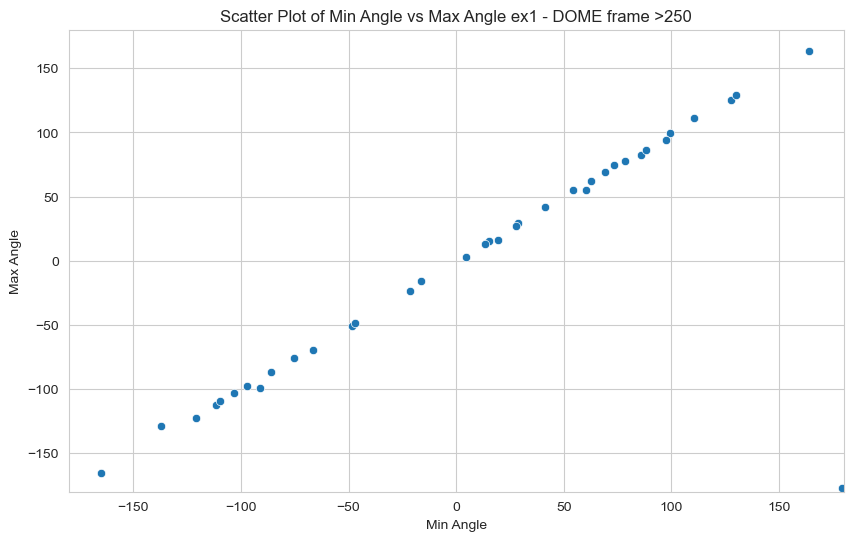

In [158]:

# Angles graph
plt.figure(figsize=(10, 6))
sns.scatterplot(x='MIN_ANGLE', y='MAX_ANGLE', data=result_df[result_df['DURATION']>250])
plt.xlabel('Min Angle')
plt.ylabel('Max Angle')

# Set x and y axis limits 
plt.xlim(-180, 180)
plt.ylim(-180, 180)

plt.title('Scatter Plot of Min Angle vs Max Angle ex1 - DOME frame >250')
plt.show()

In [160]:
loc_df= pd.DataFrame({'FRAME':range(len(image_array)), 'x': [256]*len(image_array), 'y':[256]*len(image_array)})

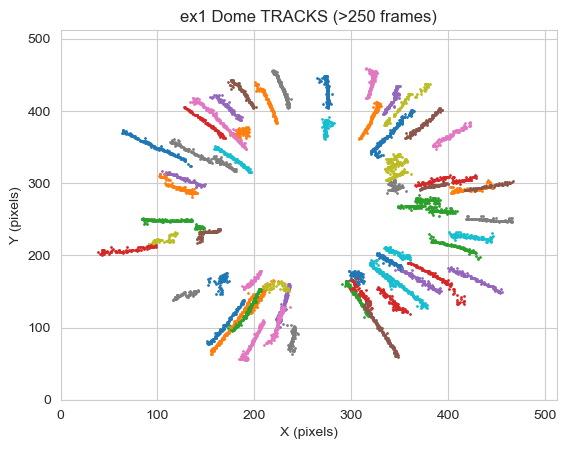

In [248]:

# Plotting the track of particles, compensated for the registration anchor, in loc_df saved in preprocessing file
long_track_id = result_df[result_df['DURATION']>250]['TRACK_ID']
long_track_id = per_track['TRACK_ID']
for track_id in long_track_id:#.iloc[np.random.randint(0,len(long_track_id), size=20)]:
    track_data = trackmate_df[trackmate_df['TRACK_ID'] == track_id]
    x = []
    y = []
    for idx, row in track_data.iterrows():    
        x.append(row['POSITION_X'] - (loc_df.loc[loc_df['FRAME'] == row['FRAME'], 'x']-256).values[0])
        y.append(row['POSITION_Y'] - (loc_df.loc[loc_df['FRAME'] == row['FRAME'], 'y']-256).values[0])

       
    plt.scatter(x,y, label = str(track_id),s=1 )
plt.title('ex1 Dome TRACKS (>250 frames)')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.xlim(0, 512)
plt.ylim(0, 512)

#plt.legend()
plt.show()

In [254]:
per_track = result_df[(np.sqrt((result_df['MAX_POSITION_X'].values - 256)**2 + (result_df['MAX_POSITION_Y'].values - 256)**2 )>90) & (result_df['MIN_FRAME']< 300 ) & (result_df['MIN_FRAME']> 200 ) & (result_df['DURATION']>120) ]
print(len(per_track))

63


In [250]:
print(per_track.describe())

           TRACK_ID   MIN_FRAME   MAX_FRAME  MIN_POSITION_X  MIN_POSITION_Y  \
count     63.000000   63.000000   63.000000       63.000000       63.000000   
mean   26189.904762  246.603175  410.825397      277.047619      256.666667   
std     1649.332854   21.472818   42.803580      120.376751      124.586801   
min    22779.000000  202.000000  332.000000       43.000000       56.000000   
25%    25220.000000  234.000000  384.000000      170.500000      150.000000   
50%    26352.000000  250.000000  404.000000      313.000000      256.000000   
75%    27203.000000  259.000000  434.000000      377.000000      366.500000   
max    30109.000000  299.000000  523.000000      465.000000      458.000000   

       MAX_POSITION_X  MAX_POSITION_Y   MIN_ANGLE   MAX_ANGLE    DURATION  
count       63.000000       63.000000   63.000000   63.000000   63.000000  
mean       274.063492      259.126984   -5.299865   -4.838835  164.222222  
std         89.816636       91.350176   94.620359   93.94523

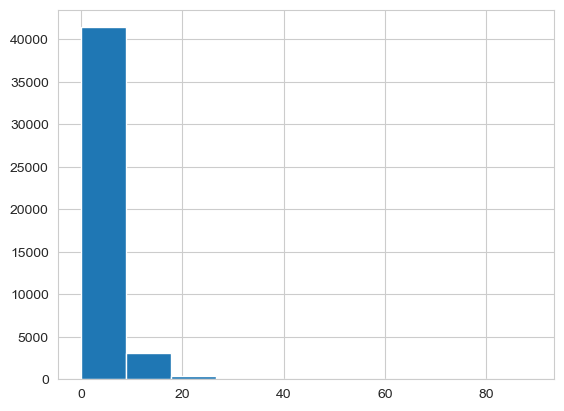

In [198]:
plt.hist(per_track['DURATION'])
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def center_of_contraction(positions, vectors):
    # Extract x, y positions and u, v vector components
    x, y = zip(*positions)
    u, v = zip(*vectors)

    # Convert to numpy arrays
    x = np.array(x)
    y = np.array(y)
    u = np.array(u)
    v = np.array(v)

    # Calculate magnitudes of vectors
    magnitudes = np.sqrt(u**2 + v**2)

    # Calculate the weighted average of positions
    x_center = np.sum(x * magnitudes) / np.sum(magnitudes)
    y_center = np.sum(y * magnitudes) / np.sum(magnitudes)

    return y_center, x_center

# Example usage
positions = [(1, 7), (2, 6), (5, 8), (7, 7), (9, 6)]
vectors = [(-1, -1), (-1, -1), (-2, -2), (-1, -1), (-1, -1)]

y_center, x_center = center_of_contraction(positions, vectors)
print(f"Center of contraction: ({x_center}, {y_center})")

# Visualization
fig, ax = plt.subplots()
ax.set_aspect('equal')

# Plot the original points and vectors
for (x, y), (u, v) in zip(positions, vectors):
    ax.quiver(x, y, u, v, angles='xy', scale_units='xy', scale=1, color='blue')

# Plot the center of contraction
ax.plot(x_center, y_center, 'ro', label='Center of contraction')

# Set plot limits
buffer = 1
ax.set_xlim(min(x) - buffer, max(x) + buffer)
ax.set_ylim(min(y) - buffer, max(y) + buffer)

# Add labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.set_title('Center of Contraction')

plt.show()

In [72]:
result_df['SIGN'] = np.sign(result_df['MIN_ANGLE'] * result_df['MAX_ANGLE'])


In [79]:
result_df.head()


,TRACK_ID,MIN_FRAME,MAX_FRAME,MIN_POSITION_X,MIN_POSITION_Y,MAX_POSITION_X,MAX_POSITION_Y,MIN_ANGLE,MAX_ANGLE,DURATION,SIGN
0,0,0,12,29,0,27,2,-134.333800,-147.855634,12,1.0
1,1,0,32,70,335,65,332,-177.510447,114.897665,32,-1.0
2,2,0,10,50,335,52,335,-177.666354,117.135140,10,-1.0
3,3,0,5,355,334,352,334,-135.000000,53.476878,5,-1.0
4,4,0,19,60,334,57,333,-177.405849,116.372137,19,-1.0


In [86]:
s = result_df['SIGN'].values
print(np.sum(s>0), np.sum(s<0))


90221 1405


C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\amityu\AppData\Local\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='DURATION', ylabel='Count'>

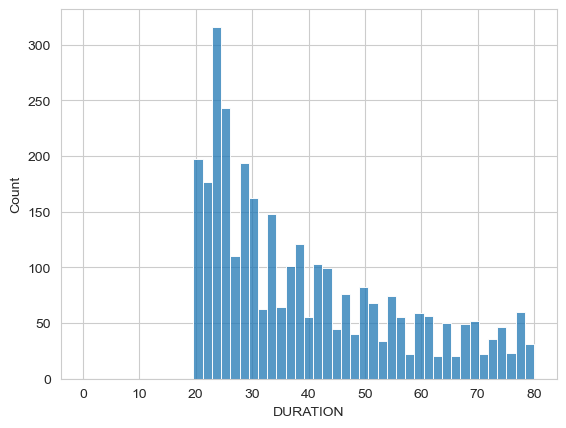

In [55]:
sns.histplot(data=result_df[result_df['DURATION']>20], x = 'DURATION', bins=np.linspace(0,80,50))

In [52]:
x = result_df['DURATION'].valuess

AttributeError: 'Series' object has no attribute 'valuess'

In [171]:
import numpy as np
from scipy.optimize import least_squares

def circle_residuals(params, x, y):
    xc, yc, r = params
    return np.sqrt((x - xc)**2 + (y - yc)**2) - r

def fit_circle(x, y):
    # Initial guess for circle parameters (x_center, y_center, radius)
    x_m = np.mean(x)
    y_m = np.mean(y)
    r_guess = np.sqrt(np.mean((x - x_m)**2 + (y - y_m)**2))
    initial_guess = [x_m, y_m, r_guess]

    # Optimize the parameters to minimize the residuals
    result = least_squares(circle_residuals, initial_guess, args=(x, y))
    xc, yc, r = result.x

    return int(yc), int(xc), np.round(r,2)

# Example usage
coordinates = [(1, 7), (2, 6), (5, 8), (7, 7), (9, 6)]
x, y = zip(*coordinates)

%time y_center, x_center, radius = fit_circle(np.array(x), np.array(y))
print(f"Circle center: ({x_center}, {y_center}), Radius: {radius}")


CPU times: total: 0 ns
Wall time: 3.68 ms
Circle center: (4, 2), Radius: 5.47


Circle center: (4.882781647847784, 2.253668497714227), Radius: 5.474099214202387


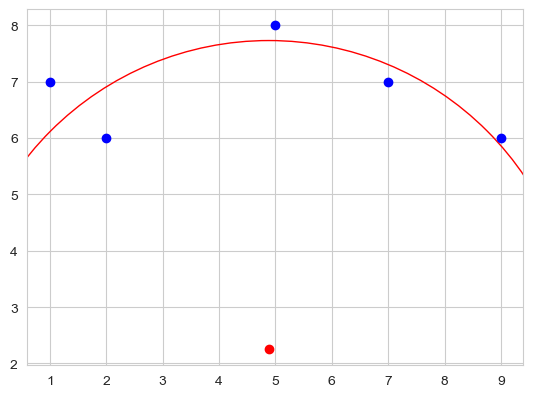

In [163]:
y_center, x_center, radius = fit_circle(np.array(x), np.array(y))
print(f"Circle center: ({x_center}, {y_center}), Radius: {radius}")

# Visualization
fig, ax = plt.subplots()
ax.set_aspect('equal')

# Plot the original points
ax.plot(x, y, 'bo', label='Data points')

# Plot the fitted circle
circle = plt.Circle((x_center, y_center), radius, color='r', fill=False, label='Fitted circle')
ax.add_artist(circle)

# Plot the center of the circle
ax.plot(x_center, y_center, 'ro', label='Circle center')
